In [1]:
from pathlib import Path
import json, math, shutil, warnings, hashlib, random, csv
from collections import defaultdict, Counter
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split

# ==== EDIT PATHS ====
SRC_DIR = Path("/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/CVPR")
DST_DIR = Path("/Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D2_hung")

TRAIN_ANN_DIR = SRC_DIR/"training/ann"
TRAIN_IMG_DIR = SRC_DIR/"training/img"
TEST_ANN_DIR  = SRC_DIR/"test/ann"
TEST_IMG_DIR  = SRC_DIR/"test/img"
META_JSON     = SRC_DIR/"meta.json"

# ==== SETTINGS ====
RANDOM_SEED = 42
VAL_RATIO = 0.15
JPEG_QUALITY = 95
DRY_RUN = False

# Decide how to treat RBCs that overlap ONLY "difficult" parasite boxes:
#   "ignore"  -> drop those RBCs entirely (strict per-paper stance)
#   "low"     -> keep as infected, stage="none", quality="low" (salvage positives; set to "ignore" to be strict)
DIFFICULT_RBC_POLICY = "ignore"

# Parasite↔RBC association thresholds
CENTER_IN_RBC = True      # primary rule: parasite center must lie within RBC box
IOU_FALLBACK_THRESH = 0.10 # if CENTER_IN_RBC fails, accept if IoU >= this

# Species for D2
SPECIES_INFECTED = "vivax"

print("SRC_DIR:", SRC_DIR)
print("DST_DIR:", DST_DIR)


SRC_DIR: /Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/CVPR
DST_DIR: /Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D2_hung


In [2]:
def read_json(p: Path):
    with open(p, "r") as f:
        return json.load(f)

def write_json(obj, p: Path):
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, "w") as f:
        json.dump(obj, f, indent=2)

def md5_str(s: str) -> str:
    import hashlib
    return hashlib.md5(s.encode("utf-8")).hexdigest()

def xywh_from_two_points(p1, p2):
    x1, y1 = int(p1[0]), int(p1[1])
    x2, y2 = int(p2[0]), int(p2[1])
    x, y = min(x1,x2), min(y1,y2)
    w, h = abs(x2 - x1), abs(y2 - y1)
    return [x, y, w, h]

def iou_xywh(a, b):
    ax, ay, aw, ah = a
    bx, by, bw, bh = b
    ax2, ay2 = ax + aw, ay + ah
    bx2, by2 = bx + bw, by + bh
    inter_x1, inter_y1 = max(ax, bx), max(ay, by)
    inter_x2, inter_y2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, inter_x2 - inter_x1), max(0, inter_y2 - inter_y1)
    inter = iw * ih
    if inter == 0: return 0.0
    union = aw*ah + bw*bh - inter
    return inter / union if union > 0 else 0.0

def center_inside(box_xywh, rb_xywh):
    x,y,w,h = box_xywh
    cx, cy = x + w/2.0, y + h/2.0
    rx, ry, rw, rh = rb_xywh
    return (rx <= cx <= rx+rw) and (ry <= cy <= ry+rh)

def log_stats(title, dct):
    print(f"\n--- {title} ---")
    for k,v in dct.items():
        print(f"{k:28s}: {v}")


In [3]:
meta = read_json(META_JSON)
classes = {c["id"]: c["title"] for c in meta.get("classes", [])}
title2id = {c["title"]: c["id"] for c in meta.get("classes", [])}
print("Classes:", classes)

STAGE_CLASSES = {"ring","trophozoite","schizont","gametocyte"}
DIFFICULT_CLASS = "difficult"
RBC_CLASS = "red blood cell"
WBC_CLASS = "leukocyte"

def list_ann_files(folder: Path):
    return sorted([p for p in folder.glob("*.json") if p.is_file()])

train_ann_files = list_ann_files(TRAIN_ANN_DIR)
test_ann_files  = list_ann_files(TEST_ANN_DIR)

log_stats("Annotation file counts", {
    "train ann json": len(train_ann_files),
    "test ann json":  len(test_ann_files),
})


Classes: {17899: 'difficult', 17900: 'gametocyte', 17901: 'leukocyte', 17895: 'red blood cell', 17897: 'ring', 17898: 'schizont', 17896: 'trophozoite'}

--- Annotation file counts ---
train ann json              : 1208
test ann json               : 120


In [4]:
@dataclass
class RBC:
    xywh: List[int]
    ann_id: str

@dataclass
class Parasite:
    xywh: List[int]
    stage: str  # ring|trophozoite|schizont|gametocyte|difficult

@dataclass
class WBC:
    xywh: List[int]

@dataclass
class ImageEntry:
    file_png: Path
    width: int
    height: int
    rbc: List[RBC]
    parasites: List[Parasite]
    wbcs: List[WBC]

def parse_ann_file(ann_path: Path, img_dir: Path) -> Optional[ImageEntry]:
    data = read_json(ann_path)
    w = data["size"]["width"]
    h = data["size"]["height"]
    # image file has same base name without ".json"
    png_name = ann_path.name.replace(".json", "")
    img_path = img_dir/png_name
    rbc_list, parasite_list, wbc_list = [], [], []

    for obj in data.get("objects", []):
        cls = obj.get("classTitle","").strip()
        if obj.get("geometryType") != "rectangle": 
            continue
        pts = obj["points"]["exterior"]
        if len(pts) < 2: 
            continue
        xywh = xywh_from_two_points(pts[0], pts[1])

        if cls == RBC_CLASS:
            key = f"{png_name}|{xywh[0]},{xywh[1]},{xywh[2]},{xywh[3]}|RBC"
            ann_id = md5_str(key)[:12]
            rbc_list.append(RBC(xywh, ann_id))
        elif cls == WBC_CLASS:
            wbc_list.append(WBC(xywh))
        elif cls in STAGE_CLASSES or cls == DIFFICULT_CLASS:
            parasite_list.append(Parasite(xywh, cls))
        else:
            # ignore other labels if any
            pass

    return ImageEntry(file_png=img_path, width=w, height=h, rbc=rbc_list, parasites=parasite_list, wbcs=wbc_list)

def parse_split(ann_files, img_dir):
    by_image = {}
    difficult_parasite_count = 0
    total_parasites = 0
    for p in ann_files:
        ent = parse_ann_file(p, img_dir)
        if ent is None: 
            continue
        by_image[ent.file_png.name] = ent
        total_parasites += len(ent.parasites)
        difficult_parasite_count += sum(1 for z in ent.parasites if z.stage == DIFFICULT_CLASS)
    log_stats("Parsed split stats", {
        "images": len(by_image),
        "RBC boxes": sum(len(e.rbc) for e in by_image.values()),
        "parasite boxes": total_parasites,
        "difficult parasite boxes": difficult_parasite_count,
        "WBC boxes": sum(len(e.wbcs) for e in by_image.values())
    })
    return by_image

train_by_image = parse_split(train_ann_files, TRAIN_IMG_DIR)
test_by_image  = parse_split(test_ann_files,  TEST_IMG_DIR)



--- Parsed split stats ---
images                      : 1208
RBC boxes                   : 77420
parasite boxes              : 2590
difficult parasite boxes    : 441
WBC boxes                   : 103

--- Parsed split stats ---
images                      : 120
RBC boxes                   : 5614
parasite boxes              : 308
difficult parasite boxes    : 5
WBC boxes                   : 0


In [5]:
def infer_rbc_attrs(entry: ImageEntry):
    """Return list of (RBC, infected, stage, quality) for one image."""
    out = []
    valid_parasites = [p for p in entry.parasites if p.stage in STAGE_CLASSES]
    difficult_only = [p for p in entry.parasites if p.stage == DIFFICULT_CLASS]
    for rb in entry.rbc:
        stages_hit = []
        # primary rule: parasite center inside RBC; fallback IoU>=thr
        for p in valid_parasites:
            if CENTER_IN_RBC and center_inside(p.xywh, rb.xywh):
                stages_hit.append(p.stage)
            elif iou_xywh(p.xywh, rb.xywh) >= IOU_FALLBACK_THRESH:
                stages_hit.append(p.stage)

        if stages_hit:
            c = Counter(stages_hit)
            top, n_top = c.most_common(1)[0]
            # tie?
            tied = [k for k,v in c.items() if v==n_top]
            if len(tied) > 1:
                out.append((rb, 1, "none", "low"))  # infected, stage ambiguous
            else:
                out.append((rb, 1, top, "high"))
        else:
            # No valid stage overlap. Check if ONLY difficult overlaps exist.
            hit_difficult = False
            for p in difficult_only:
                if CENTER_IN_RBC and center_inside(p.xywh, rb.xywh):
                    hit_difficult = True; break
                if iou_xywh(p.xywh, rb.xywh) >= IOU_FALLBACK_THRESH:
                    hit_difficult = True; break

            if hit_difficult:
                if DIFFICULT_RBC_POLICY == "ignore":
                    # do not include this RBC in dataset at all
                    continue
                elif DIFFICULT_RBC_POLICY == "low":
                    out.append((rb, 1, "none", "low"))
                else:
                    out.append((rb, 0, "none", "high"))  # conservative
            else:
                # Uninfected
                out.append((rb, 0, "none", "high"))
    return out

# Build inferred attributes for train/test images
train_inferred = {name: infer_rbc_attrs(ent) for name, ent in train_by_image.items()}
test_inferred  = {name: infer_rbc_attrs(ent) for name, ent in test_by_image.items()}

def summarize_inferred(split_dict):
    n_img = len(split_dict)
    n_rbc = sum(len(v) for v in split_dict.values())
    n_inf = sum(sum(1 for x in v if x[1]==1) for v in split_dict.values())
    st_cnt = Counter()
    for v in split_dict.values():
        for (_, inf, st, q) in v:
            if inf==1 and st!="none":
                st_cnt[st]+=1
    return n_img, n_rbc, n_inf, st_cnt

tr_img, tr_rbc, tr_inf, tr_stages = summarize_inferred(train_inferred)
te_img, te_rbc, te_inf, te_stages = summarize_inferred(test_inferred)

log_stats("Inferred (train)", {
    "images": tr_img, "RBC total": tr_rbc, "infected RBC": tr_inf, "stage dist": dict(tr_stages)
})
log_stats("Inferred (test)", {
    "images": te_img, "RBC total": te_rbc, "infected RBC": te_inf, "stage dist": dict(te_stages)
})



--- Inferred (train) ---
images                      : 1208
RBC total                   : 77265
infected RBC                : 975
stage dist                  : {'trophozoite': 767, 'ring': 104, 'schizont': 70, 'gametocyte': 34}

--- Inferred (test) ---
images                      : 120
RBC total                   : 5613
infected RBC                : 96
stage dist                  : {'trophozoite': 46, 'ring': 42, 'gametocyte': 5, 'schizont': 2}


In [6]:
def pil_ok(path: Path) -> bool:
    try:
        with Image.open(path) as im:
            im.load()
        return True
    except (UnidentifiedImageError, FileNotFoundError, OSError) as e:
        warnings.warn(f"Corrupt/missing: {path.name} ({e})")
        return False

# Filter out corrupt images
def filter_corrupt(split_inferred, base_img_dir):
    ok = {}
    bad = []
    for name, items in split_inferred.items():
        p = base_img_dir/name
        if pil_ok(p):
            ok[name] = items
        else:
            bad.append(name)
    return ok, bad

train_inferred, bad_train = filter_corrupt(train_inferred, TRAIN_IMG_DIR)
test_inferred,  bad_test  = filter_corrupt(test_inferred,  TEST_IMG_DIR)

log_stats("Corrupt filtering", {"train dropped": len(bad_train), "test dropped": len(bad_test)})

# Stratified split by infected count/image
train_names = sorted(train_inferred.keys())
inf_counts = np.array([sum(1 for x in train_inferred[n] if x[1]==1) for n in train_names])
bins = np.digitize(inf_counts, bins=[0,1,3,6], right=True)
X = np.arange(len(train_names))
idx_tr, idx_val = train_test_split(X, test_size=VAL_RATIO, random_state=RANDOM_SEED, stratify=bins)
train_names_split = [train_names[i] for i in idx_tr]
val_names_split   = [train_names[i] for i in idx_val]

log_stats("Split (images)", {
    "train": len(train_names_split),
    "val": len(val_names_split),
    "test": len(test_inferred)
})



--- Corrupt filtering ---
train dropped               : 0
test dropped                : 0

--- Split (images) ---
train                       : 1026
val                         : 182
test                        : 120


In [7]:
CAT_RBC = 1
CAT_WBC = 2  # optional

CATEGORIES = [{"id": CAT_RBC, "name": "RBC"}, {"id": CAT_WBC, "name": "WBC"}]

def build_coco_sidecar_from_inferred(split_names, split_inferred, split_by_image, img_dir, species_for_infected=SPECIES_INFECTED):
    images, annotations = [], []
    sidecar = defaultdict(dict)
    ann_id_auto, img_id_auto = 1, 1

    for name in split_names:
        ent = split_by_image[name]
        images.append({"id": img_id_auto,
                       "file_name": name.replace(".png", ".jpg"),
                       "width": ent.width,
                       "height": ent.height})

        # RBCs with inferred attributes
        for rb, infected, stage, quality in split_inferred[name]:
            x,y,w,h = rb.xywh
            annotations.append({
                "id": ann_id_auto,
                "image_id": img_id_auto,
                "category_id": CAT_RBC,
                "bbox": [x,y,w,h],
                "area": w*h,
                "iscrowd": 0
            })
            sidecar[name.replace(".png",".jpg")][str(ann_id_auto)] = {
                "infected": infected,
                "species": species_for_infected if infected==1 else "none",
                "stage": stage,
                "quality": quality
            }
            ann_id_auto += 1

        # Optional WBC distractors (no sidecar)
        for wbc in ent.wbcs:
            x,y,w,h = wbc.xywh
            annotations.append({
                "id": ann_id_auto,
                "image_id": img_id_auto,
                "category_id": CAT_WBC,
                "bbox": [x,y,w,h],
                "area": w*h,
                "iscrowd": 0
            })
            ann_id_auto += 1

        img_id_auto += 1

    coco = {"images": images, "annotations": annotations, "categories": CATEGORIES}
    return coco, sidecar

COCO_train, SC_train = build_coco_sidecar_from_inferred(train_names_split, train_inferred, train_by_image, TRAIN_IMG_DIR)
COCO_val,   SC_val   = build_coco_sidecar_from_inferred(val_names_split,   train_inferred, train_by_image, TRAIN_IMG_DIR)
COCO_test,  SC_test  = build_coco_sidecar_from_inferred(sorted(test_inferred.keys()), test_inferred, test_by_image, TEST_IMG_DIR)

log_stats("COCO sizes", {
    "train images": len(COCO_train["images"]), "train ann": len(COCO_train["annotations"]),
    "val images": len(COCO_val["images"]),     "val ann": len(COCO_val["annotations"]),
    "test images": len(COCO_test["images"]),   "test ann": len(COCO_test["annotations"]),
})



--- COCO sizes ---
train images                : 1026
train ann                   : 66267
val images                  : 182
val ann                     : 11101
test images                 : 120
test ann                    : 5613


In [8]:
# Create folders
(IM_TRAIN := (DST_DIR/"images/train")).mkdir(parents=True, exist_ok=True)
(IM_VAL   := (DST_DIR/"images/val")).mkdir(parents=True, exist_ok=True)
(IM_TEST  := (DST_DIR/"images/test")).mkdir(parents=True, exist_ok=True)
(ANNO_DIR := (DST_DIR/"annotations")).mkdir(parents=True, exist_ok=True)
(META_DIR := (DST_DIR/"meta")).mkdir(parents=True, exist_ok=True)

# Write JSONs
write_json(COCO_train, ANNO_DIR/"coco_train.json")
write_json(SC_train,   ANNO_DIR/"sidecar_train.json")
write_json(COCO_val,   ANNO_DIR/"coco_val.json")
write_json(SC_val,     ANNO_DIR/"sidecar_val.json")
write_json(COCO_test,  ANNO_DIR/"coco_test.json")
write_json(SC_test,    ANNO_DIR/"sidecar_test.json")
print("Wrote COCO + sidecar JSONs →", ANNO_DIR)

def convert_copy(names, src_dir, dst_dir):
    copied, skipped = 0, 0
    for name in names:
        src = src_dir/name
        dst = dst_dir/name.replace(".png",".jpg")
        if DRY_RUN:
            copied += 1; continue
        try:
            with Image.open(src) as im:
                im = im.convert("RGB")
                im.save(dst, format="JPEG", quality=JPEG_QUALITY, optimize=True)
            copied += 1
        except Exception as e:
            warnings.warn(f"Failed convert/copy: {name} ({e})")
            skipped += 1
    return copied, skipped

cop_t, sk_t = convert_copy(train_names_split, TRAIN_IMG_DIR, IM_TRAIN)
cop_v, sk_v = convert_copy(val_names_split,   TRAIN_IMG_DIR, IM_VAL)
cop_e, sk_e = convert_copy(sorted(test_inferred.keys()), TEST_IMG_DIR, IM_TEST)

log_stats("Image conversion", {
    "train copied": cop_t, "train skipped": sk_t,
    "val copied":   cop_v, "val skipped":   sk_v,
    "test copied":  cop_e, "test skipped":  sk_e
})


Wrote COCO + sidecar JSONs → /Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D2_hung/annotations

--- Image conversion ---
train copied                : 1026
train skipped               : 0
val copied                  : 182
val skipped                 : 0
test copied                 : 120
test skipped                : 0


In [9]:
# Enums
classes_species = ["falciparum","vivax","malariae","ovale","knowlesi","none"]
classes_stage   = ["ring","trophozoite","schizont","gametocyte","none"]
write_json(classes_species, META_DIR/"classes_species.json")
write_json(classes_stage,   META_DIR/"classes_stage.json")

# α (inverse-frequency, smoothed) from TRAIN ONLY (excluding 'none')
def count_attr(sidecar, key):
    c = Counter()
    for fname, d in sidecar.items():
        for annid, attr in d.items():
            val = attr.get(key, "none")
            if val != "none":
                c[val] += 1
    return c

sp_counts = count_attr(SC_train, "species")  # expect "vivax" only
st_counts = count_attr(SC_train, "stage")

def invfreq_alpha(all_classes, counts):
    eps = 1.0
    kv = []
    for c in all_classes:
        if c == "none": 
            continue
        w = 1.0 / (counts.get(c,0) + eps)
        kv.append((c, w))
    s = sum(w for _,w in kv)
    kv = [(c, w/s) for c,w in kv]
    return dict(kv)

alpha_species = invfreq_alpha(classes_species, sp_counts)
alpha_stage   = invfreq_alpha(classes_stage,   st_counts)

write_json(alpha_species, META_DIR/"class_weights_species.json")
write_json(alpha_stage,   META_DIR/"class_weights_stage.json")

# Transforms (fill in later if you apply stain/scale normalization)
transforms = {"stain_normalization": "pending", "scale_px_per_rbc_target": "pending"}
write_json(transforms, META_DIR/"transforms.json")

# Split index (file_name → split)
with open(META_DIR/"split_index.csv","w",newline="") as f:
    w = csv.writer(f); w.writerow(["image_name","split"])
    for n in train_names_split: w.writerow([n.replace(".png",".jpg"), "train"])
    for n in val_names_split:   w.writerow([n.replace(".png",".jpg"), "val"])
    for n in sorted(test_inferred.keys()): w.writerow([n.replace(".png",".jpg"), "test"])

# Audit CSV (one row per box)
def dump_audit(coco, sc, split, writer):
    id2name = {im["id"]: im["file_name"] for im in coco["images"]}
    for ann in coco["annotations"]:
        img_name = id2name[ann["image_id"]]
        x,y,w,h = ann["bbox"]
        cid = ann["category_id"]
        if cid == CAT_RBC:
            attrs = sc[img_name][str(ann["id"])]
            writer.writerow([img_name, ann["id"], x,y,w,h, "RBC",
                             attrs["infected"], attrs["species"], attrs["stage"], attrs["quality"], split])
        else:
            writer.writerow([img_name, ann["id"], x,y,w,h, "WBC", "", "", "", "", split])

with open(META_DIR/"audit_master.csv","w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["image_name","ann_id","x","y","w","h","category",
                "infected","species","stage","quality","split"])
    dump_audit(COCO_train, SC_train, "train", w)
    dump_audit(COCO_val,   SC_val,   "val",   w)
    dump_audit(COCO_test,  SC_test,  "test",  w)

print("Meta written →", META_DIR)
print("alpha_species:", alpha_species)
print("alpha_stage:", alpha_stage)


Meta written → /Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D2_hung/meta
alpha_species: {'falciparum': 0.24992481203007516, 'vivax': 0.0003007518796992481, 'malariae': 0.24992481203007516, 'ovale': 0.24992481203007516, 'knowlesi': 0.24992481203007516}
alpha_stage: {'ring': 0.17106836799841738, 'trophozoite': 0.023730520560756068, 'schizont': 0.26840037048027554, 'gametocyte': 0.5368007409605511}



[train] images=1026  RBC=66171  WBC=96  INF=830  UN=65341  stages={'trophozoite': 655, 'ring': 90, 'schizont': 57, 'gametocyte': 28}

[val] images=182  RBC=11094  WBC=7  INF=145  UN=10949  stages={'trophozoite': 112, 'ring': 14, 'schizont': 13, 'gametocyte': 6}

[test] images=120  RBC=5613  WBC=0  INF=96  UN=5517  stages={'trophozoite': 46, 'ring': 42, 'gametocyte': 5, 'none': 1, 'schizont': 2}


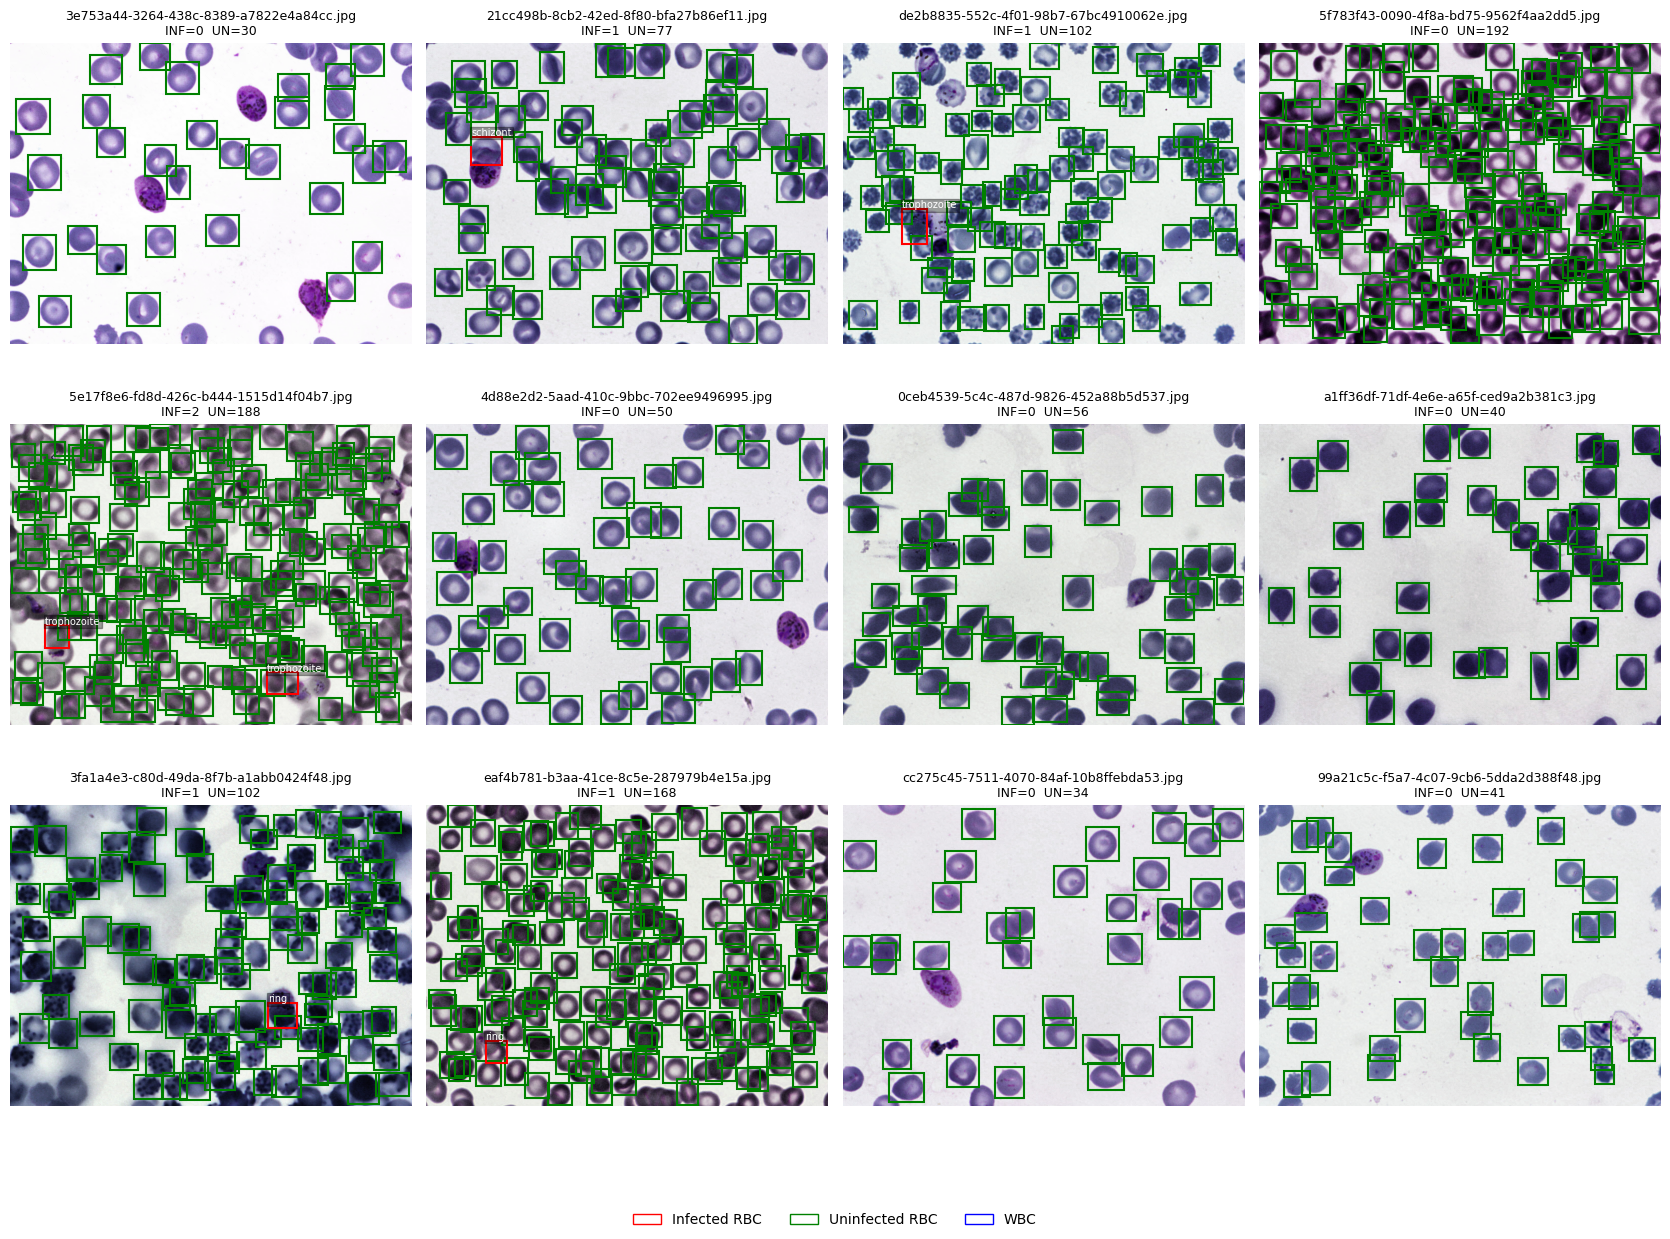

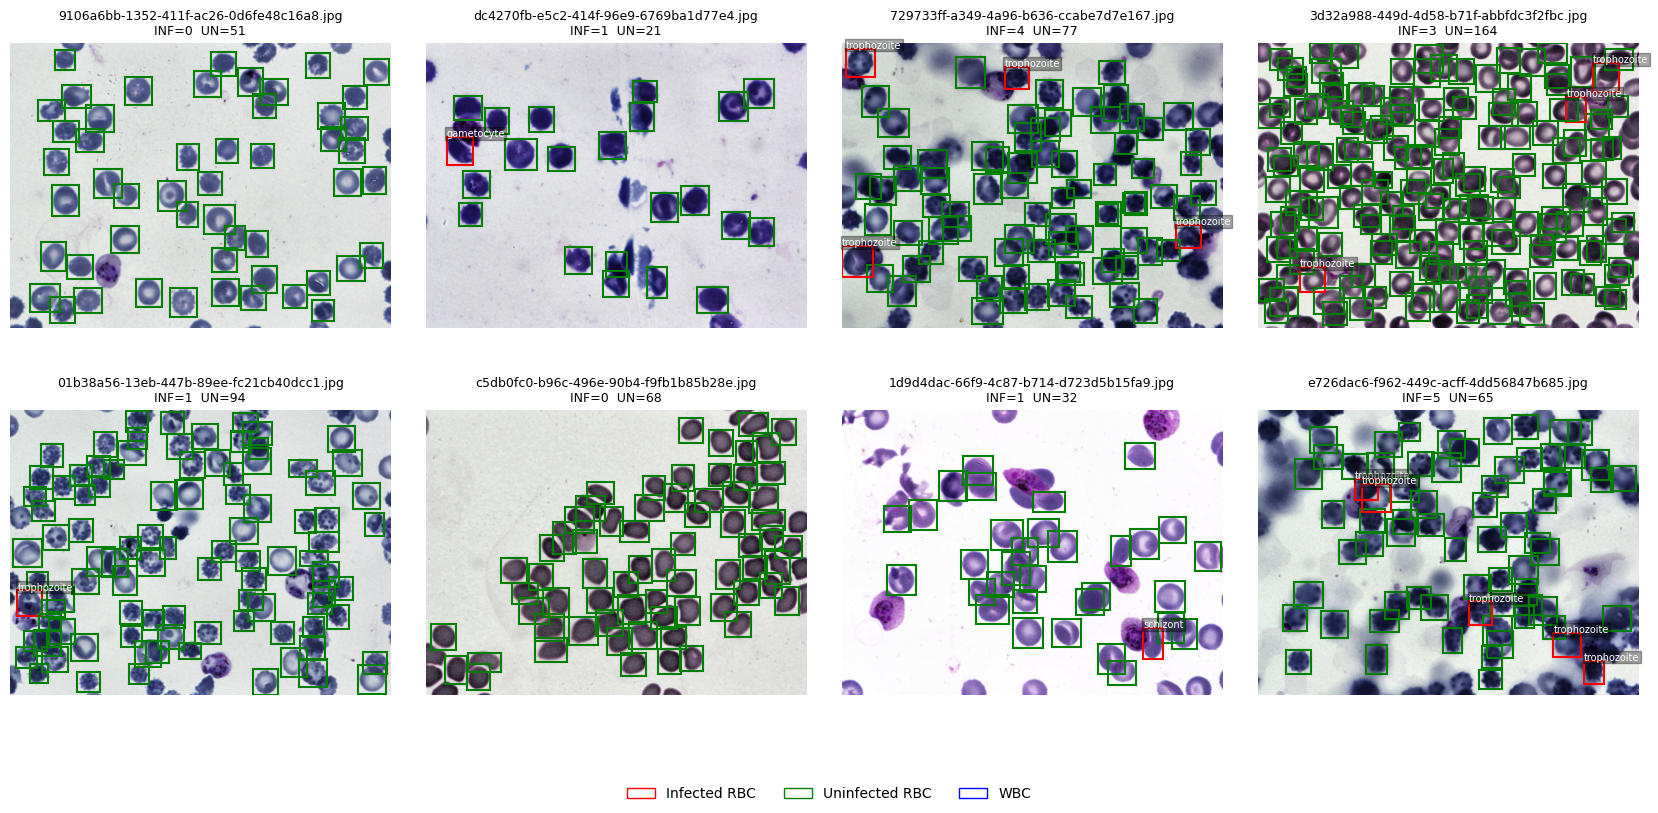

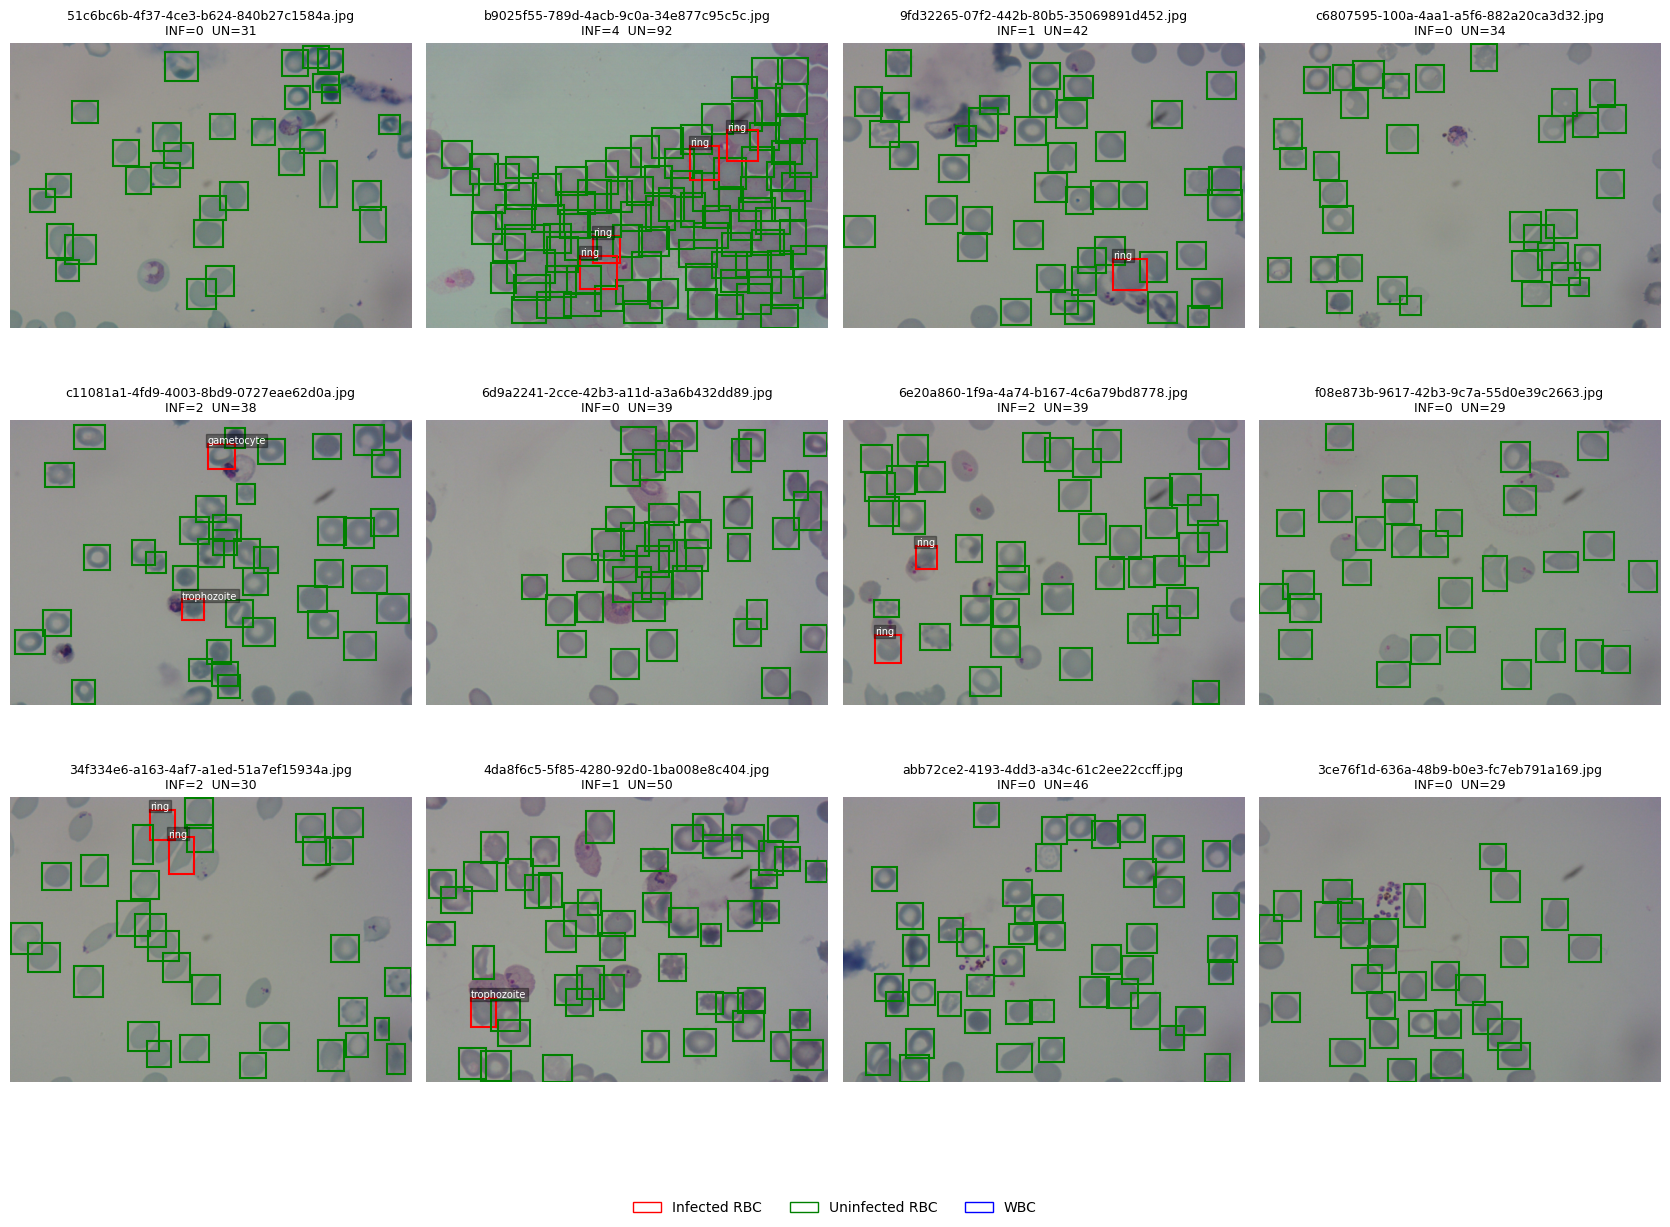

In [10]:
import math, random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def split_stats(coco, sidecar, name):
    n_img = len(coco["images"])
    anns = coco["annotations"]
    rbc = [a for a in anns if a["category_id"]==CAT_RBC]
    wbc = [a for a in anns if a["category_id"]==CAT_WBC]
    inf = sum(sidecar[a_img := next(im["file_name"] for im in coco["images"] if im["id"]==a["image_id"])][str(a["id"])]["infected"]
              for a in rbc)
    st = Counter(
        sidecar[next(im["file_name"] for im in coco["images"] if im["id"]==a["image_id"])][str(a["id"])]["stage"]
        for a in rbc if sidecar[next(im["file_name"] for im in coco["images"] if im["id"]==a["image_id"])][str(a["id"])]["infected"]==1
    )
    print(f"\n[{name}] images={n_img}  RBC={len(rbc)}  WBC={len(wbc)}  INF={inf}  UN={len(rbc)-inf}  stages={dict(st)}")

def show_examples_grid(coco, sidecar, img_dir, k=12, ncols=4, seed=0, lw=1.5):
    rng = random.Random(seed)
    id2name = {im["id"]: im["file_name"] for im in coco["images"]}
    anns_by_imgid = defaultdict(list)
    for ann in coco["annotations"]:
        anns_by_imgid[ann["image_id"]].append(ann)
    img_ids = list(id2name.keys())
    if not img_ids:
        print("No images to display."); return
    rng.shuffle(img_ids)
    img_ids = img_ids[:min(k, len(img_ids))]
    nrows = math.ceil(len(img_ids)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 4.2*nrows))
    axes = np.array(axes).reshape(nrows, ncols)

    for idx, iid in enumerate(img_ids):
        r, c = idx//ncols, idx%ncols
        ax = axes[r, c]
        name = id2name[iid]
        path = img_dir/name
        if not path.exists():
            ax.axis('off'); ax.set_title(f"{name} (missing)"); continue
        with Image.open(path) as im:
            ax.imshow(im)

        inf_cnt, un_cnt = 0, 0
        for ann in anns_by_imgid[iid]:
            x,y,w,h = ann["bbox"]
            if ann["category_id"] == CAT_RBC:
                attrs = sidecar[name][str(ann["id"])]
                color = 'red' if attrs["infected"]==1 else 'green'
                inf_cnt += (attrs["infected"]==1)
                un_cnt  += (attrs["infected"]==0)
                rect = patches.Rectangle((x,y), w,h, linewidth=lw, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                if attrs["infected"]==1 and attrs["stage"]!="none":
                    ax.text(x, max(0,y-2), f"{attrs['stage']}", fontsize=7, color='white',
                            bbox=dict(facecolor='black', alpha=0.35, pad=1))
            elif ann["category_id"] == CAT_WBC:
                rect = patches.Rectangle((x,y), w,h, linewidth=lw, edgecolor='blue', facecolor='none')
                ax.add_patch(rect)

        ax.set_title(f"{name}\nINF={inf_cnt}  UN={un_cnt}", fontsize=9)
        ax.axis('off')

    # hide unused axes
    for idx in range(len(img_ids), nrows*ncols):
        r, c = idx//ncols, idx%ncols
        axes[r, c].axis('off')

    legend_patches = [Patch(edgecolor='red', facecolor='none', label='Infected RBC'),
                      Patch(edgecolor='green', facecolor='none', label='Uninfected RBC'),
                      Patch(edgecolor='blue', facecolor='none', label='WBC')]
    fig.legend(handles=legend_patches, loc='lower center', ncol=3, frameon=False)
    plt.tight_layout(rect=[0,0.05,1,1]); plt.show()

# Print stats
split_stats(COCO_train, SC_train, "train")
split_stats(COCO_val,   SC_val,   "val")
split_stats(COCO_test,  SC_test,  "test")

# Visual grids
if not DRY_RUN:
    show_examples_grid(COCO_train, SC_train, DST_DIR/"images/train", k=12, ncols=4, seed=1)
    show_examples_grid(COCO_val,   SC_val,   DST_DIR/"images/val",   k=8,  ncols=4, seed=2)
    show_examples_grid(COCO_test,  SC_test,  DST_DIR/"images/test",  k=12, ncols=4, seed=3)
